### Logistic Regression with PCA

by Piyush Sanghi

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection, preprocessing, linear_model, metrics, decomposition

#### 1. Data Processing:

###### a) Import the data: Only keep numeric data (pandas has tools to do this!). Drop "PHONE" and "COUNTRY_SSA" as well. Verify that your data has the following shape: (15617, 28)

In [2]:
df = pd.read_csv('ProviderInfo.csv')

In [3]:
df = df.select_dtypes(['number'])

In [4]:
df = df.drop(['PHONE', 'COUNTY_SSA'], axis=1)

In [5]:
df.shape

(15617, 28)

###### b) This data is extra messy and has some NaN and NaT values, which need to be removed completely. Hint: NaT values should be replaced by "np.nan." After this step, remove any rows that have an NaN value. Verify that your dataframe was properly updated to the following shape: (14557, 28)

In [6]:
df.dropna(inplace=True) #drop na handles both NaN and NaT

In [7]:
df.shape

(14557, 28)

###### c) Split into train / test set using an 80/20 split.

In [8]:
X = df.drop(['OVERALL_RATING'], axis=1)
y = df[['OVERALL_RATING']]

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=10)

###### d) Scale X_train data properly (Do not scale the Target Variable): Recall from HW #2 the proper method of scaling.

In [10]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [11]:
X_train_scaled = scaler.transform(X_train)

In [12]:
X_test_scaled = scaler.transform(X_test)

#### 2. Model #1: Logistic Regression

###### a) Pick up from step d in Problem 1 (use the same data that has been scaled): Using LogisticRegression(), build a model to predict the "OVERALL_RATING". Note: The default in sklearn is "one-vs-rest" classification, where we calculate the probability of each class compared to the rest. Please use this for your homework.

In [13]:
logit = linear_model.LogisticRegression(random_state=10)
logit.fit(X_train_scaled, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

###### b) For error evaluation, start by calculating the score (returns the mean accuracy).You can use the .score() method. 

In [14]:
logit.score(X_train_scaled, y_train)

0.7002146844139115

###### c) Calculate the confusion matrix and classification report for the test data (both are in sklearn.metrics). To do this, you will need to first predict the class of each observation in the test data. 

Function to calculate and print confusion matrix and classification report

In [15]:
def calculate_confusion_matrix_and_classification_report(y_actual, y_predicted):
    #Printing the classification report
    print('-------------  Classification Report  -------------')
    print(metrics.classification_report(y_actual, y_predicted))
    
    print('-------------  Confusion Matrix  -------------')
    
    conf_matrix = metrics.confusion_matrix(y_actual, y_predicted)
    conf_matrix = pd.DataFrame(data=conf_matrix, columns=range(1, 6), index=range(1, 6)) #converting to dataframe
    
    #Plotting the confusion matrix
    sns.set(font_scale=1.5)
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 14}, cmap="YlGnBu", fmt='g')   

In [16]:
y_pred = logit.predict(X_test_scaled)

-------------  Classification Report  -------------
             precision    recall  f1-score   support

        1.0       0.78      0.82      0.80       319
        2.0       0.54      0.69      0.61       590
        3.0       0.41      0.15      0.22       480
        4.0       0.64      0.68      0.66       662
        5.0       0.90      0.97      0.93       861

avg / total       0.67      0.70      0.67      2912

-------------  Confusion Matrix  -------------


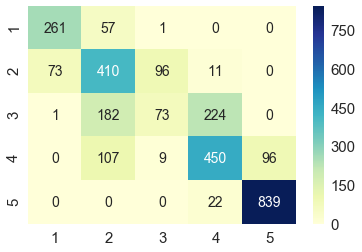

In [17]:
calculate_confusion_matrix_and_classification_report(y_test, y_pred)

###### d) Based on the confusion matrix and classification report, do any of the classes get predicted exceptionally poorly? If so, comment briefly on what might be causing this to happen (Hint: Very open-ended). 

Based on the confusion matrix and classification report, we can see that class 3 is being predicted very poorly. From the confusion matrix we see that many observations belonging to class 3 are being predicted as either 2 or 4. This could be due to similar observations between class 2, 3 and 4 causing the decision boundary between 2 and 3, 3 and 4 to be skewed in favor of 2 and 4.

###### e) Calculate predictions for the training data & build the confusion matrix and classification report. Are there signs of overfitting? Why or why not?

In [18]:
y_train_pred = logit.predict(X_train_scaled)

-------------  Classification Report  -------------
             precision    recall  f1-score   support

        1.0       0.81      0.79      0.80      1380
        2.0       0.54      0.73      0.62      2308
        3.0       0.44      0.15      0.23      1913
        4.0       0.64      0.68      0.66      2656
        5.0       0.88      0.97      0.92      3388

avg / total       0.68      0.70      0.67     11645

-------------  Confusion Matrix  -------------


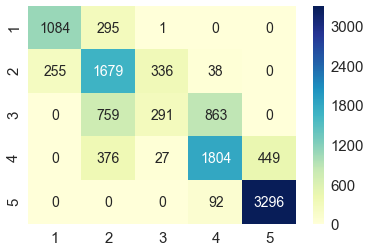

In [19]:
calculate_confusion_matrix_and_classification_report(y_train, y_train_pred)

Based on the confusion matrix, classification report between train and test, we do not see signs of over-fitting as accuracy, f1-score is consistent between train and test. If there was any over-fitting, we would have seen difference in numbers between train and test. 

###### f) Print out an example of the predicted probability. There is a method called .predict_proba() which can be used for estimating these values on the test set. This will be critical to understand for future questions. 

In [20]:
logit.predict_proba(X_test_scaled)[:2] #Printing probabilities for the first 2 observations in the test set.

array([[5.27168039e-04, 4.41556359e-01, 2.96136720e-01, 2.58836250e-01,
        2.94350265e-03],
       [1.76373619e-06, 6.14257032e-02, 8.17897624e-02, 1.88456977e-01,
        6.68325793e-01]])

#### 3. Model #2: PCA(n_components = 2) + Logistic Regression

###### a) Pick up from step d in Problem 1 (use the same data that has been scaled): We will now transform the X_train & X_test data using PCA with 2 components. Hint: the PCA class in sklearn can be used similarly to how we have used StandardScaler class (fit_transform on train and transform on test). 

- Transform X_train and call it X_train_pca_2
- Transform X_test and call it X_test_pca_2

In [21]:
pca = decomposition.PCA(n_components=2)
X_train_pca_2 = pca.fit_transform(X_train_scaled)
X_test_pca_2 = pca.transform(X_test_scaled)

###### b) Then use the transformed data (X_train_pca_2) to fit a Logistic Regression model.

In [22]:
logit_pca_2 = linear_model.LogisticRegression()
logit_pca_2.fit(X_train_pca_2, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

###### c) Calculate the confusion matrix and classification report for the test data

In [23]:
y_pred = logit_pca_2.predict(X_test_pca_2)

-------------  Classification Report  -------------
             precision    recall  f1-score   support

        1.0       0.37      0.42      0.39       319
        2.0       0.29      0.41      0.34       590
        3.0       0.00      0.00      0.00       480
        4.0       0.26      0.05      0.09       662
        5.0       0.45      0.81      0.58       861

avg / total       0.29      0.38      0.30      2912

-------------  Confusion Matrix  -------------


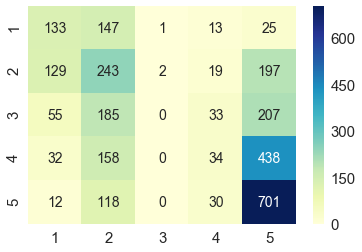

In [24]:
calculate_confusion_matrix_and_classification_report(y_test, y_pred)

###### d) Calculate predictions for the training data & build the confusion matrix and classification report. Are there signs of overfitting? Why or why not?

-------------  Classification Report  -------------
             precision    recall  f1-score   support

        1.0       0.44      0.41      0.43      1380
        2.0       0.29      0.41      0.34      2308
        3.0       0.18      0.00      0.00      1913
        4.0       0.23      0.05      0.08      2656
        5.0       0.43      0.83      0.57      3388

avg / total       0.32      0.38      0.30     11645

-------------  Confusion Matrix  -------------


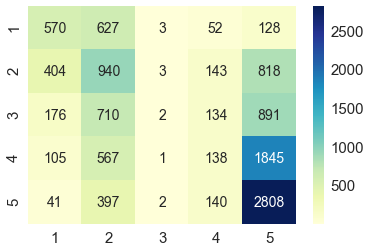

In [25]:
y_train_pred = logit_pca_2.predict(X_train_pca_2)
calculate_confusion_matrix_and_classification_report(y_train, y_train_pred)

Between train and test, the classification report (f1-score) and confusion matrix look similar, which means we do not have over-fitting, however the error rate is extremely high for both, train and test. This high error rate seems like the model is underfitting.

###### e) How well does this model perform relative to Model #1? Explain why there is a shift in performance. 

The model does not perform well related to vanilla logistic regression model (model 1) as both train and test are high. A reason for the high error could be due to the fact that we are only taking into account 2 principal components. These 2 components do not seem to explain high amount of variance within the data, due to which model is unable to predict the class correctly.

In [26]:
pca.explained_variance_ratio_

array([0.23097122, 0.15057179])

In [27]:
sum(pca.explained_variance_ratio_)

0.3815430104661651

As we can see from the results above, the 2 principal components are able to explain only 38% of the variance in data. Hence the poor results while predicting classes.

#### 4. Model #3: PCA(n_components = 16) + Logistic Regression

###### a) Pick up from step d in Problem 1 (use the same data that has been scaled): We will now transform the X_train & X_test data using PCA with 16 components. 

- Transform X_train and call it X_train_pca_16
- Transform X_test and call it X_test_pca_16


In [28]:
pca = decomposition.PCA(n_components=16)
X_train_pca_16 = pca.fit_transform(X_train_scaled)
X_test_pca_16 = pca.transform(X_test_scaled)

###### b) Then use the transformed data (X_train_pca_16) to fit a Logistic Regression model.

In [29]:
logit_pca_16 = linear_model.LogisticRegression()
logit_pca_16.fit(X_train_pca_16, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

###### c) Calculate the confusion matrix and classification report for the test data

-------------  Classification Report  -------------
             precision    recall  f1-score   support

        1.0       0.78      0.81      0.80       319
        2.0       0.54      0.70      0.61       590
        3.0       0.42      0.15      0.22       480
        4.0       0.64      0.68      0.66       662
        5.0       0.89      0.98      0.93       861

avg / total       0.67      0.70      0.67      2912

-------------  Confusion Matrix  -------------


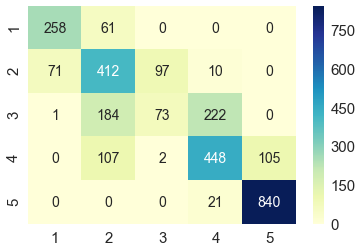

In [30]:
y_pred = logit_pca_16.predict(X_test_pca_16)
calculate_confusion_matrix_and_classification_report(y_test, y_pred)

###### d) Calculate predictions for the training data & build the confusion matrix and classification report. Are there signs of overfitting? Why or why not?

-------------  Classification Report  -------------
             precision    recall  f1-score   support

        1.0       0.80      0.78      0.79      1380
        2.0       0.53      0.72      0.61      2308
        3.0       0.45      0.15      0.22      1913
        4.0       0.64      0.66      0.65      2656
        5.0       0.87      0.98      0.92      3388

avg / total       0.67      0.69      0.67     11645

-------------  Confusion Matrix  -------------


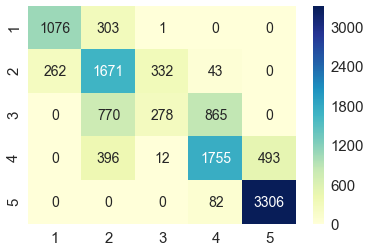

In [31]:
y_pred_train = logit_pca_16.predict(X_train_pca_16)
calculate_confusion_matrix_and_classification_report(y_train, y_pred_train)

Between train and test, the classification report (f1-score) and confusion matrix look similar, which does not indicate any signs of over-fitting.

In [32]:
pca.explained_variance_ratio_

array([0.23097122, 0.15057179, 0.12094185, 0.0980974 , 0.07210533,
       0.04685808, 0.04080419, 0.03722839, 0.03203778, 0.02695287,
       0.02626602, 0.02471917, 0.02261184, 0.02174634, 0.01821652,
       0.01598879])

In [33]:
sum(pca.explained_variance_ratio_)

0.9861175796001751